In [1]:
from xcube.core.store import new_data_store
import xarray as xr
import pandas as pd
import numpy as np
import os
import dask
import dask.array as da
from dask.distributed import Client, LocalCluster
from xcube_resampling import resample_in_time

In [2]:
cluster = LocalCluster(
    n_workers=16,
    threads_per_worker=1,
    memory_limit="1.8GB",   # per worker
)
client = Client(cluster)
client.dashboard_link

'http://127.0.0.1:8787/status'

In [3]:
%%time
team_store = new_data_store(
    "s3", 
    root=os.environ["S3_USER_STORAGE_BUCKET"], 
    storage_options=dict(
        anon=False, 
        key=os.environ["S3_USER_STORAGE_KEY"], 
        secret=os.environ["S3_USER_STORAGE_SECRET"],
    )
)

CPU times: user 62.4 ms, sys: 41.2 ms, total: 104 ms
Wall time: 163 ms


In [13]:
team_store.list_data_ids()

['oc_cci.zarr',
 'oc_glo_cmems_300m.zarr',
 'oc_glo_cmems_4km.zarr',
 'oc_nws_cmems.levels',
 'oc_nws_cmems.zarr',
 'sen2_l2a.levels',
 'sen2_l2a.zarr',
 'sen2l2a.levels',
 'sen2l2a0.levels',
 'sen2l2a2.levels',
 'sen2l2a3.levels',
 'sen2l2a_stavanger_large0.zarr',
 'sen2l2a_stavanger_large2.zarr',
 'sen2l2a_stavanger_large3.zarr']

---

In [3]:
store = new_data_store("stac-pc-ardc")

In [4]:
store.list_data_ids()

['sentinel-2-l2a']

In [ ]:
%%time
time_ranges = (
    ("2023-06-01", "2023-06-08"),
    ("2023-06-09", "2023-06-16"),
    ("2023-06-17", "2023-06-24"),
    ("2023-06-25", "2023-06-30"),
)

In [ ]:
%%time
for i, time_range in enumerate(time_ranges):
    ds = store.open_data(
        "sentinel-2-l2a",
        time_range=time_range,
        bbox=[4.3, 58.0, 6.5, 59.6],
        spatial_res=10 / 111320,
        crs="EPSG:4326",
        asset_names=["B02", "B03", "B04", "B08", "SCL"],
        tile_size=(2048, 2048),
    )
    team_store.write_data(ds,f"sen2_l2a_{i}.zarr", replace=True)

---

In [4]:
data_ids = ["sen2l2a0.levels", "sen2l2a.levels", "sen2l2a2.levels", "sen2l2a3.levels"]
dss = []
for data_id in data_ids:
    mlds = team_store.open_data(data_id)
    dss.append(mlds.get_dataset(0))

In [5]:
lat = dss[0]["lat"]
lon = dss[0]["lon"]
new_time = pd.to_datetime(["2023-06-01T10:00:00"])

lazy_nans = da.full(
    (1, dss[0].sizes["lat"], dss[0].sizes["lon"]),
    np.nan,
    chunks=dss[0].B02.data.chunksize
)
empty_slice = xr.DataArray(
    lazy_nans,
    dims=("time", "lat", "lon"),
    coords={"time": new_time, "lat": lat, "lon": lon},
)

# If your dataset has multiple variables, wrap in Dataset:
empty_ds = xr.Dataset(
    {var: empty_slice.copy() for var in dss[0].data_vars}
)
empty_ds

<xarray.Dataset> Size: 17GB
Dimensions:  (time: 1, lat: 17813, lon: 24492)
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-06-01T10:00:00
  * lat      (lat) float64 143kB 59.6 59.6 59.6 59.6 ... 58.0 58.0 58.0 58.0
  * lon      (lon) float64 196kB 4.3 4.3 4.3 4.3 4.3 4.3 ... 6.5 6.5 6.5 6.5 6.5
Data variables:
    B02      (time, lat, lon) float64 3GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03      (time, lat, lon) float64 3GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04      (time, lat, lon) float64 3GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B08      (time, lat, lon) float64 3GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL      (time, lat, lon) float64 3GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [6]:
# 3) Concatenate the new slice in *front*
ds = xr.concat([empty_ds] + dss, dim="time")
ds

<xarray.Dataset> Size: 332GB
Dimensions:      (time: 19, lat: 17813, lon: 24492)
Coordinates:
  * time         (time) datetime64[ns] 152B 2023-06-01T10:00:00 ... 2023-06-3...
  * lat          (lat) float64 143kB 59.6 59.6 59.6 59.6 ... 58.0 58.0 58.0 58.0
  * lon          (lon) float64 196kB 4.3 4.3 4.3 4.3 4.3 ... 6.5 6.5 6.5 6.5 6.5
    spatial_ref  int64 8B 0
Data variables:
    B02          (time, lat, lon) float64 66GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, lat, lon) float64 66GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, lat, lon) float64 66GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B08          (time, lat, lon) float64 66GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, lat, lon) float64 66GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [7]:
#data_ids = [f"sen2_l2a_{i}.zarr" for i in range(4)]
#dss = []
#for data_id in data_ids:
#    dss.append(team_store.open_data(data_id))
#ds = xr.concat(dss, "time")
#ds

In [8]:
%%time
ds = resample_in_time(ds, frequency="1D", agg_methods="mean")
ds

CPU times: user 677 ms, sys: 29.2 ms, total: 707 ms
Wall time: 692 ms


<xarray.Dataset> Size: 524GB
Dimensions:      (lat: 17813, lon: 24492, time: 30)
Coordinates:
  * lat          (lat) float64 143kB 59.6 59.6 59.6 59.6 ... 58.0 58.0 58.0 58.0
  * lon          (lon) float64 196kB 4.3 4.3 4.3 4.3 4.3 ... 6.5 6.5 6.5 6.5 6.5
  * time         (time) datetime64[ns] 240B 2023-06-01 2023-06-02 ... 2023-06-30
    spatial_ref  int64 8B 0
Data variables:
    B02_mean     (time, lat, lon) float64 105GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03_mean     (time, lat, lon) float64 105GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04_mean     (time, lat, lon) float64 105GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B08_mean     (time, lat, lon) float64 105GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL_mean     (time, lat, lon) float64 105GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    time_coverage_start:  <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...
    time_coverage_end:    <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...

In [ ]:
%%time
ds = team_store.open_data("sen2_l2a.zarr")
ds = ds.rename(
    {
        "B02_mean": "B02",
        "B03_mean": "B03",
        "B04_mean": "B04",
        "B08_mean": "B08",
        "SCL_mean": "SCL",
    }
)
ds

In [12]:
%%time
team_store.write_data(ds, "sen2_l2a.levels", num_levels=5, replace=True)

CPU times: user 11min 54s, sys: 1min 54s, total: 13min 49s
Wall time: 32min 21s


'sen2_l2a.levels'

In [3]:
mlds = team_store.open_data("sen2_l2a.levels")
ds = mlds.get_dataset(4)
ds

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 29, lat: 1114, lon: 1531)
Coordinates:
  * time         (time) datetime64[ns] 232B 2023-06-02 2023-06-03 ... 2023-06-30
  * lat          (lat) float64 9kB 59.6 59.6 59.6 59.59 ... 58.0 58.0 58.0 58.0
  * lon          (lon) float64 12kB 4.3 4.301 4.303 4.304 ... 6.496 6.498 6.499
    spatial_ref  int64 8B ...
Data variables:
    B02_mean     (time, lat, lon) float32 198MB dask.array<chunksize=(1, 1114, 1531), meta=np.ndarray>
    B03_mean     (time, lat, lon) float32 198MB dask.array<chunksize=(1, 1114, 1531), meta=np.ndarray>
    B04_mean     (time, lat, lon) float32 198MB dask.array<chunksize=(1, 1114, 1531), meta=np.ndarray>
    B08_mean     (time, lat, lon) float32 198MB dask.array<chunksize=(1, 1114, 1531), meta=np.ndarray>
    SCL_mean     (time, lat, lon) float64 396MB dask.array<chunksize=(1, 1114, 1531), meta=np.ndarray>
Attributes:
    stac_catalog_url:     https://planetarycomputer.microsoft.com/api/stac/v1
    stac_item_ids:        {'2023-06-02T10:56:29.024000': ['S2B_MSIL2A_2023060...
    time_coverage_end:    <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...
    time_coverage_start:  <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...
    xcube_stac_version:   1.1.1

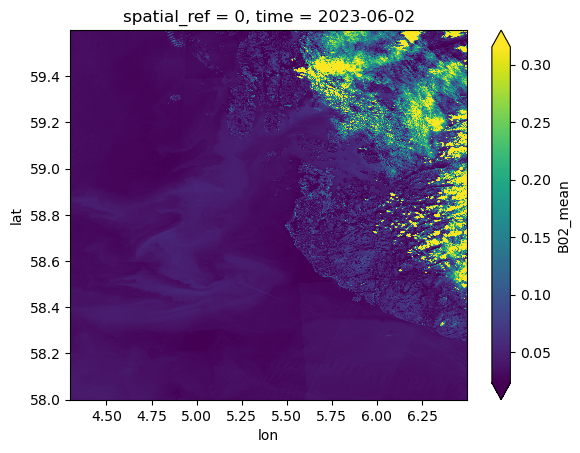

In [4]:
ds.B02_mean.isel(time=0).plot(robust=True)